In [52]:
import pandas as pd

from traineval.train_eval import TrainerEvaluator
from tqdm import tqdm
from traineval.utils.convert_arguments import get_environment_arguments
from matplotlib import pyplot as plt

import numpy as np
import os.path as osp
from traineval.training.spinningup import data as saved_models
%matplotlib inline

In [53]:
def create_model_env_arguments(model_type, number_of_epochs, model_seed, save_freq):

    # The arguments you want the agent to use
    district_args = ["hour",
                     "month",
                     "carbon_intensity",
                     "electricity_pricing"]

    building_args = ["electrical_storage_soc",
                     "net_electricity_consumption"]

    environment_arguments = get_environment_arguments(district_args, building_args)

    model_args = [
        [['--env'], str, 'Epoch-Citylearn-v1'],
        [['--hid'], int, 64],
        [['--l'], int, 3],
        [['--gamma'], float, 0.99],
        [['--seed', '-s'], int, model_seed],
        [['--cpu'], int, 4],
        [['--steps'], int, 4000],
        [['--epochs'], int, number_of_epochs],
        [['--exp_name'], str, model_type],
        [['--save_freq'], int, save_freq],
        [['--max_ep_len'], int, 1000]
        ]

    return model_args, environment_arguments

In [54]:
def get_training_times(model_type, model_seed, eval_freq, num_epochs):
    progress_path = model_type + '/' + model_type + '_s' + str(model_seed) + '/progress.txt'
    full_path = osp.join(osp.dirname(saved_models.__file__), progress_path)
    all_data = pd.read_table(full_path)
    time_column = all_data["Time"]
    epoch_column = all_data["Epoch"]
    return list(time_column)[::eval_freq][0:int(num_epochs/eval_freq) + 1], list(epoch_column)[::eval_freq][0:int(num_epochs/eval_freq) + 1]

In [55]:
def get_evaluation_data(trainer_evaluator, model_type, model_seed, num_epochs, eval_freq):
    training_times, epochs = get_training_times(model_type, model_seed, eval_freq, num_epochs)
    averaged_scores = []
    for epoch in tqdm(range(0, num_epochs + 1, eval_freq)):
        # TODO: make this run in parallel
        averaged_score, agent_time = trainer_evaluator.run_evaluation(model_type=model_type, model_seed=model_seed, model_iteration=epoch, verbose=True)
        averaged_scores.append(averaged_score)
        # if epoch + eval_freq >= num_epochs and epoch != num_epochs - 1:
        #     averaged_score, agent_time = trainer_evaluator.run_evaluation(model_type=model_type, model_seed=model_seed, model_iteration=epoch, verbose=False)
        #     averaged_scores.append(averaged_score)
    print(training_times, averaged_scores, epochs)
    return pd.DataFrame({"averages":averaged_scores, "times": training_times})


In [56]:
def plot_and_save(title, xs, ys, xlabel, ylabel):
    fig,ax=plt.subplots()
    ax.plot(xs, ys, marker="o")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    # ax.plot(gapminder_us.year, gapminder_us["gdpPercap"], marker="o")
    plt.savefig(title)
    plt.show()

In [57]:
number_of_epochs = 200
model_type = "ppo"
model_args, environment_arguments = create_model_env_arguments(model_type=model_type, number_of_epochs=number_of_epochs, model_seed=0, save_freq=20)

trainer_evaluator = TrainerEvaluator(model_args=model_args, environment_arguments=environment_arguments)
df_costs_times = get_evaluation_data(trainer_evaluator=trainer_evaluator, model_type=model_type, model_seed=0, num_epochs=number_of_epochs, eval_freq=20)

ppo_untuned_title = str.strip(f"{model_type}-{number_of_epochs}epochs")
plot_and_save(title=ppo_untuned_title, xs=df_costs_times.times, ys=df_costs_times.averages, xlabel="Time spent training (s)", ylabel="Average cost")

  0%|          | 0/6 [00:00<?, ?it/s]

Starting local evaluation


  0%|          | 0/6 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x14 and 1x64)

In [51]:
number_of_epochs = 200
model_type = "ppo"
model_args, environment_arguments = create_model_env_arguments(model_type=model_type, number_of_epochs=number_of_epochs, model_seed=0, save_freq=20)

trainer_evaluator = TrainerEvaluator(model_args=model_args, environment_arguments=environment_arguments)
df_costs_times = get_evaluation_data(trainer_evaluator=trainer_evaluator, model_type=model_type, model_seed=0, num_epochs=number_of_epochs, eval_freq=40)

ppo_untuned_title = str.strip(f"{model_type}-{number_of_epochs}epochs")
plot_and_save(title=ppo_untuned_title, xs=df_costs_times.times, ys=df_costs_times.averages, xlabel="Time spent training (s)", ylabel="Average cost")

  0%|          | 0/6 [00:00<?, ?it/s]

Starting local evaluation


  0%|          | 0/6 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x14 and 1x64)

100%|██████████| 3/3 [04:00<00:00, 80.33s/it]


[2250.277771949768, 4379.741956233978, 6522.672401666641] [1.1104352506630846, 1.061720518989668, 1.6631321586664976]


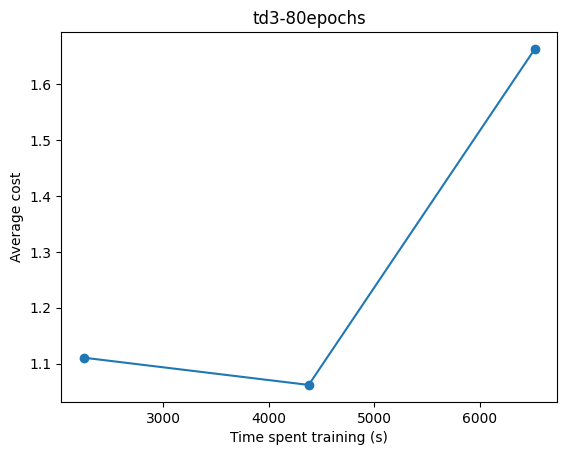

In [33]:
number_of_epochs = 80
model_type = "td3"
model_args, environment_arguments = create_model_env_arguments(model_type=model_type, number_of_epochs=number_of_epochs, model_seed=0, save_freq=20)

trainer_evaluator = TrainerEvaluator(model_args=model_args, environment_arguments=environment_arguments)
df_costs_times = get_evaluation_data(trainer_evaluator=trainer_evaluator, model_type=model_type, model_seed=0, num_epochs=number_of_epochs, eval_freq=20)

ppo_untuned_title = str.strip(f"{model_type}-{number_of_epochs}epochs")
plot_and_save(title=ppo_untuned_title, xs=df_costs_times.times, ys=df_costs_times.averages, xlabel="Time spent training (s)", ylabel="Average cost")